In [1]:
# 2024 MAY 30

In [2]:
import numpy as np
import pandas as pd

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    precision_recall_curve, roc_curve)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# data

## load & preview

In [5]:
diabetes_data = pd.read_csv("../data/pima_indian_diabetes.csv")

# preview
display(diabetes_data.head(3))

# target {0: negative, 1: positive}
print(diabetes_data["Outcome"].value_counts())

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


Outcome
0    500
1    268
Name: count, dtype: int64


In [6]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [7]:
X = diabetes_data.iloc[:, :-1]
Y = diabetes_data.iloc[:, -1]

## analysis

In [8]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### glucose histogram

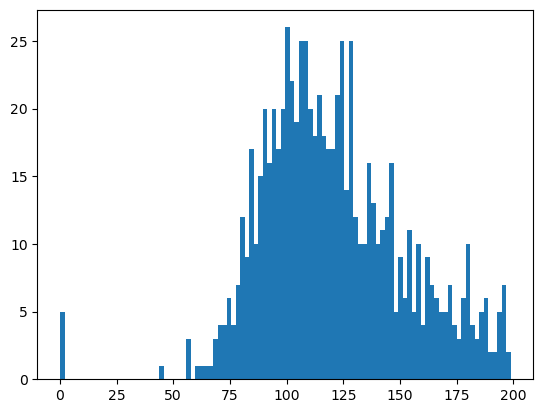

In [9]:
plt.hist(diabetes_data["Glucose"], bins=100)
plt.show()

### investigate zero-valued features

In [10]:
features_having_zeros = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

num_data_in_a_feature = diabetes_data["Glucose"].count()

for feature in features_having_zeros:
    num_zeros = diabetes_data[diabetes_data[feature] == 0][feature].count()
    print(f"{feature}:\n number of {0}s: {num_zeros:3.0F}, percentage being {num_zeros/num_data_in_a_feature*100:5.2F}%")

Glucose:
 number of 0s:   5, percentage being  0.65%
BloodPressure:
 number of 0s:  35, percentage being  4.56%
SkinThickness:
 number of 0s: 227, percentage being 29.56%
Insulin:
 number of 0s: 374, percentage being 48.70%
BMI:
 number of 0s:  11, percentage being  1.43%


# preprocessing

## replace inadequate zero values

In [11]:
# replace zero-valued features to average value
diabetes_data[features_having_zeros] = diabetes_data[features_having_zeros].replace(0, diabetes_data[features_having_zeros].mean())

# diabetes_data[features_having_zeros].mean() gives mean for each feature having zeros.

# check change
print(diabetes_data.describe())

for feature in features_having_zeros:
    num_zeros = diabetes_data[diabetes_data[feature] == 0][feature].count()
    print(f"{feature}:\n number of {0}s: {num_zeros:3.0F}, percentage being {num_zeros/num_data_in_a_feature*100:5.2F}%")

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  121.681605      72.254807      26.606479  118.660163   
std       3.369578   30.436016      12.115932       9.631241   93.080358   
min       0.000000   44.000000      24.000000       7.000000   14.000000   
25%       1.000000   99.750000      64.000000      20.536458   79.799479   
50%       3.000000  117.000000      72.000000      23.000000   79.799479   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    32.450805                  0.471876   33.240885    0.348958  
std      6.875374                  0.331329   11.760232    0.476951  
min     18.200000                  

## scaling

In [12]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=156, stratify=Y)

# model

In [13]:
classifier = LogisticRegression(solver="liblinear")

classifier.fit(X_train, Y_train)
Y_pred = classifier.predict(X_test)
pred_proba_posi = classifier.predict_proba(X_test)[:, 1]

# evaluation

In [14]:
def evaluate(Y_test, Y_pred, pred_proba_posi):
    # confusion matrix
    print("confusion matrix:\n", confusion_matrix(Y_test, Y_pred))
    
    # accuracy, precision & recall, F1 score
    print(f"accuracy      : {accuracy_score(Y_test, Y_pred):.4F}")
    print(f"precision     : {precision_score(Y_test, Y_pred):.4F}")
    print(f"recall        : {recall_score(Y_test, Y_pred):.4F}")
    print(f"F1 score      : {f1_score(Y_test, Y_pred):.4F}")
    print(f"ROC AUC score : {roc_auc_score(Y_test, pred_proba_posi):.4F}")

    print("\n")

In [15]:
def plot_precision_recall_curve(y_test, proba_posi):
    precisions, recalls, thresholds = precision_recall_curve(y_test, proba_posi)
    
    plt.figure()
    num_thresholds = thresholds.shape[0];
    
    plt.plot(thresholds, precisions[0:num_thresholds], linestyle='--', label="precision")
    plt.plot(thresholds, recalls[0:num_thresholds], label="recall")
    
    # options
    x_start, x_end = plt.xlim()
    plt.xticks(np.round(np.arange(x_start, x_end, 0.1), 2))
    
    plt.xlabel("Threshold");
    plt.ylabel("Precision, Recall");
    plt.legend();
    plt.grid();
    plt.show();

In [16]:
evaluate(Y_test, Y_pred, pred_proba_posi)

confusion matrix:
 [[90 10]
 [21 33]]
accuracy      : 0.7987
precision     : 0.7674
recall        : 0.6111
F1 score      : 0.6804
ROC AUC score : 0.8059




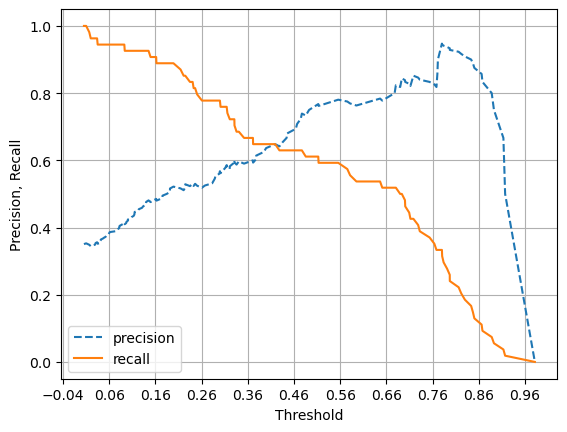

In [17]:
plot_precision_recall_curve(Y_test, pred_proba_posi)

## confidence threshold sweep

In [18]:
from sklearn.preprocessing import Binarizer

In [19]:
def evaluate_for_each_threshold(Y_test, pred_proba_posi, thresholds):
    for threshold in thresholds:
        print("threshold:", threshold)
        
        binarizer = Binarizer(threshold=threshold)
        binarizer.fit(pred_proba_posi)
        binarized_Y_pred = binarizer.transform(pred_proba_posi)
        
        evaluate(Y_test, binarized_Y_pred, pred_proba_posi)

In [20]:
thresholds = np.round(np.linspace(0.3, 0.5, 8), 2)

pred_proba_posi = classifier.predict_proba(X_test)[:, 1].reshape(-1, 1)
evaluate_for_each_threshold(Y_test, pred_proba_posi, thresholds)

threshold: 0.3
confusion matrix:
 [[68 32]
 [13 41]]
accuracy      : 0.7078
precision     : 0.5616
recall        : 0.7593
F1 score      : 0.6457
ROC AUC score : 0.8059


threshold: 0.33
confusion matrix:
 [[74 26]
 [15 39]]
accuracy      : 0.7338
precision     : 0.6000
recall        : 0.7222
F1 score      : 0.6555
ROC AUC score : 0.8059


threshold: 0.36
confusion matrix:
 [[76 24]
 [18 36]]
accuracy      : 0.7273
precision     : 0.6000
recall        : 0.6667
F1 score      : 0.6316
ROC AUC score : 0.8059


threshold: 0.39
confusion matrix:
 [[79 21]
 [19 35]]
accuracy      : 0.7403
precision     : 0.6250
recall        : 0.6481
F1 score      : 0.6364
ROC AUC score : 0.8059


threshold: 0.41
confusion matrix:
 [[81 19]
 [19 35]]
accuracy      : 0.7532
precision     : 0.6481
recall        : 0.6481
F1 score      : 0.6481
ROC AUC score : 0.8059


threshold: 0.44
confusion matrix:
 [[83 17]
 [20 34]]
accuracy      : 0.7597
precision     : 0.6667
recall        : 0.6296
F1 score      : 0.6476


In [21]:
# consider threshold=0.47 is good.
optimal_threshold = 0.47
binarizer = Binarizer(threshold=optimal_threshold)

binarized_Y_pred = binarizer.fit_transform(pred_proba_posi)
evaluate(Y_test, binarized_Y_pred, pred_proba_posi)

confusion matrix:
 [[87 13]
 [20 34]]
accuracy      : 0.7857
precision     : 0.7234
recall        : 0.6296
F1 score      : 0.6733
ROC AUC score : 0.8059


